## Model Evaluation and Implementation

After developing and testing two powerful machine learning models, we use key performance metrics to compare them. Using advanced model selection techniques specifically for financial modeling, we will select one model. With that model, we will: develop a business strategy, estimate portfolio value, and minimize expected loss.

### Comparing model reports
You've used logistic regression models and gradient boosted trees. It's time to compare these two to see which model will be used to make the final predictions.

One of the easiest first steps for comparing different models' ability to predict the probability of default is to look at their metrics from the classification_report(). With this, you can see many different scoring metrics side-by-side for each model. Because the data and models are normally unbalanced with few defaults, focus on the metrics for defaults for now.

In [9]:
### prob_default with logistic 

import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

# read data
cr_loan = pd.read_csv("cr_loan2.csv")

# Impute the null values with the median value for all employment lengths
cr_loan['person_emp_length'].fillna((cr_loan['person_emp_length'].median()), inplace=True)


# Store the array on indices
indices = cr_loan[cr_loan['loan_int_rate'].isnull()].index

# Save the new data without missing data
cr_loan_clean = cr_loan.drop(indices)


# Create the X and y data sets
X = cr_loan_clean[['loan_int_rate', 'person_emp_length', 'person_income']]
y = cr_loan_clean[['loan_status']]

# Use test_train_split to create the training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.4, random_state=123)

# Create and fit the logistic regression mode
clf_logistic = LogisticRegression(solver='lbfgs').fit(X_train, np.ravel(y_train))

# Create predictions of probability for loan status using test data
preds = clf_logistic.predict_proba(X_test)

# Create a dataframe for the probabilities of default
preds_df_lr = pd.DataFrame(preds[:,1], columns = ['prob_default'])

# Reassign loan status based on the threshold
preds_df_lr['loan_status'] = pred_df_lr['prob_default'].apply(lambda x: 1 if x > 0.50 else 0)

print(preds_df_lr)

       prob_default  loan_status
0          0.203595            0
1          0.137401            0
2          0.119622            0
3          0.307440            0
4          0.505785            1
...             ...          ...
11781      0.117611            0
11782      0.478990            0
11783      0.343653            0
11784      0.040130            0
11785      0.049490            0

[11786 rows x 2 columns]


In [14]:
### prob_default with XGB

import xgboost as xgb

# Predict with a model
clf_gbt = xgb.XGBClassifier().fit(X_train, np.ravel(y_train))

# Predict the labels for loan status
preds_df_gbt = clf_gbt.predict(X_test)

[15:10:22] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

In [13]:
from sklearn.metrics import classification_report, precision_recall_fscore_support

# Print the logistic regression classification report
target_names = ['Non-Default', 'Default']
print(classification_report(y_test,preds_df_lr['loan_status'], target_names=target_names))

# Print the gradient boosted tree classification report
print(classification_report(y_test, preds_df_gbt, target_names=target_names))

# Print the default F-1 scores for the logistic regression
print(precision_recall_fscore_support(y_test,preds_df_lr['loan_status'], average = 'macro')[2])

# Print the default F-1 scores for the gradient boosted tree
print(precision_recall_fscore_support(y_test,preds_df_gbt, average = 'macro')[2])

              precision    recall  f1-score   support

 Non-Default       0.81      0.96      0.88      9194
     Default       0.62      0.22      0.33      2592

    accuracy                           0.80     11786
   macro avg       0.72      0.59      0.61     11786
weighted avg       0.77      0.80      0.76     11786

              precision    recall  f1-score   support

 Non-Default       0.86      0.96      0.91      9194
     Default       0.74      0.45      0.56      2592

    accuracy                           0.84     11786
   macro avg       0.80      0.70      0.73     11786
weighted avg       0.83      0.84      0.83     11786

0.6051472893670924
0.7336016242947945


### Comparing with ROCs
You should use ROC charts and AUC scores to compare the two models. Sometimes, visuals can really help you and potential business users understand the differences between the various models under consideration.

With the graph in mind, you will be more equipped to make a decision. The lift is how far the curve is from the random prediction. The AUC is the area between the curve and the random prediction. The model with more lift, and a higher AUC, is the one that's better at making predictions accurately.

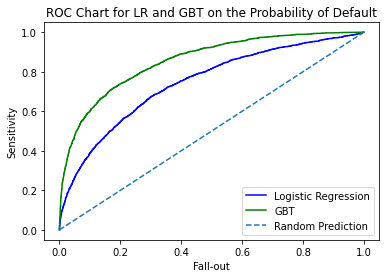

In [16]:
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

# ROC chart components
fallout_lr, sensitivity_lr, thresholds_lr = roc_curve(y_test, pred_df_lr['prob_default'])
fallout_gbt, sensitivity_gbt, thresholds_gbt = roc_curve(y_test, clf_gbt.predict_proba(X_test)[:,1])

# ROC Chart with both
plt.plot(fallout_lr, sensitivity_lr, color = 'blue', label='%s' % 'Logistic Regression')
plt.plot(fallout_gbt, sensitivity_gbt, color = 'green', label='%s' % 'GBT')
plt.plot([0, 1], [0, 1], linestyle='--', label='%s' % 'Random Prediction')
plt.title("ROC Chart for LR and GBT on the Probability of Default")
plt.xlabel('Fall-out')
plt.ylabel('Sensitivity')
plt.legend()
plt.show()

In [17]:
# Print the logistic regression AUC with formatting
print("Logistic Regression AUC Score: %0.2f" % roc_auc_score(y_test, pred_df_lr['prob_default']))

# Print the gradient boosted tree AUC with formatting
print("Gradient Boosted Tree AUC Score: %0.2f" % roc_auc_score(y_test, clf_gbt.predict_proba(X_test)[:,1]))

Logistic Regression AUC Score: 0.74
Gradient Boosted Tree AUC Score: 0.86


Look at the ROC curve for the gradient boosted tree. Not only is the lift much higher, the calculated AUC score is also quite a bit higher. It's beginning to look like the gradient boosted tree is best. Let's check the calibration to be sure.

### Calibration curves
You now know that the gradient boosted tree clf_gbt has the best overall performance. You need to check the calibration of the two models to see how stable the default prediction performance is across probabilities. You can use a chart of each model's calibration to check this by calling the calibration_curve() function.

Calibration curves can require many lines of code in python, so you will go through each step slowly to add the different components.

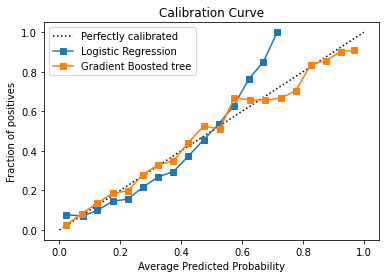

In [24]:
from sklearn.calibration import calibration_curve
    
# calibration curves
frac_of_pos_lr, mean_pred_val_lr = calibration_curve(y_test, pred_df_lr['prob_default'], n_bins = 20)
frac_of_pos_gbt, mean_pred_val_gbt  = calibration_curve(y_test, clf_gbt.predict_proba(X_test)[:,1], n_bins = 20)

# Add the calibration curve for the gradient boosted tree
plt.plot([0, 1], [0, 1], 'k:', label='Perfectly calibrated')    
plt.plot(mean_pred_val_lr, frac_of_pos_lr,
         's-', label='%s' % 'Logistic Regression')
plt.plot(mean_pred_val_gbt, frac_of_pos_gbt,
         's-', label='%s' % "Gradient Boosted tree")
plt.ylabel('Fraction of positives')
plt.xlabel('Average Predicted Probability')
plt.legend()
plt.title('Calibration Curve')
plt.show()

Notice that for the logistic regression, the calibration for probabilities starts off great but then gets more erratic as it the average probability approaches 0.4. Something similar happens to the gradient boosted tree around 0.5, but the model eventually stabilizes. We will be focusing on only the gbt model from now on.

### Acceptance rates
Setting an acceptance rate and calculating the threshold for that rate can be used to set the percentage of new loans you want to accept. For this exercise, assume the test data is a fresh batch of new loans. You will need to use the quantile() function from numpy to calculate the threshold.

The threshold should be used to assign new loan_status values. Does the number of defaults and non-defaults in the data change?

In [53]:
prob_default_gbt = clf_gbt.predict_proba(X_test)[:,1]

predsdf_gbt = pd.DataFrame(prob_default_gbt, columns = ['prob_default'])

predsdf_gbt['loan_status'] = preds_df_gbt

# Check the statistics of the probabilities of default
print(predsdf_gbt['prob_default'].describe())

# Calculate the threshold for a 95% acceptance rate
threshold_95 = np.quantile(prob_default_gbt, .95)

# Apply acceptance rate threshold
predsdf_gbt['pred_loan_status'] = predsdf_gbt['loan_status'] .apply(lambda x: 1 if x > threshold_85 else 0)

# Print the counts of loan status after the threshold
print(predsdf_gbt['pred_loan_status'].value_counts())

count    11786.000000
mean         0.217585
std          0.248146
min          0.000244
25%          0.041043
50%          0.118782
75%          0.294687
max          0.995789
Name: prob_default, dtype: float64
0    10213
1     1573
Name: pred_loan_status, dtype: int64


### Visualizing quantiles of acceptance
You know how quantile() works to compute a threshold, and you've seen an example of what it does to split the loans into accepted and rejected. What does this threshold look like for the test set, and how can you visualize it?

To check this, you can create a histogram of the probabilities and add a reference line for the threshold. With this, you can visually show where the threshold exists in the distribution.

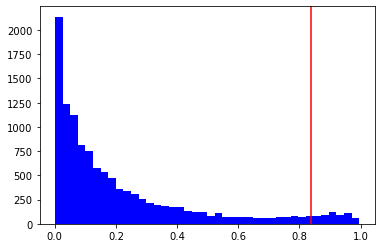

In [65]:
# Plot the predicted probabilities of default
plt.hist(predsdf_gbt['prob_default'], color = 'blue', bins = 40)

# Calculate the threshold with quantile
threshold = np.quantile(predsdf_gbt['prob_default'], .95)

# Add a reference line to the plot for the threshold
plt.axvline(x = threshold, color = 'red')
plt.show() 

### Bad rates
With acceptance rate in mind, you can now analyze the bad rate within the accepted loans. This way you will be able to see the percentage of defaults that have been accepted.

Think about the impact of the acceptance rate and bad rate. We set an acceptance rate to have fewer defaults in the portfolio because defaults are more costly. Will the bad rate be less than the percentage of defaults in the test data?

In [66]:
# Create a subset of only accepted loans
accepted_loans = predsdf_gbt[predsdf_gbt['pred_loan_status'] == 0]

# Calculate the bad rate
print(np.sum(accepted_loans['loan_status']) / accepted_loans ['loan_status'].count())

0.0


### Acceptance rate impact
Now, look at the loan_amnt of each loan to understand the impact on the portfolio for the acceptance rates. You can use cross tables with calculated values, like the average loan amount, of the new set of loans X_test. For this, you will multiply the number of each with an average loan_amnt value.

In [67]:
# Store the average loan amount
avg_loan = np.mean(cr_loan_clean['loan_amnt'])

# Set the formatting for currency, and print the cross tab
pd.options.display.float_format = '${:,.2f}'.format
print(pd.crosstab(predsdf_gbt['loan_status'],
                 predsdf_gbt['pred_loan_status']).apply(lambda x: x * avg_loan, axis = 0))

pred_loan_status             0              1
loan_status                                  
0                $6,038,389.11 $91,850,607.62
1                        $0.00 $15,076,803.28


### Making the strategy table
Before you implement a strategy, you should first create a strategy table containing all the possible acceptance rates you wish to look at along with their associated bad rates and threshold values. This way, you can begin to see each part of your strategy and how it affects your portfolio.

Automatically calculating all of these values only requires a for loop, but requires many lines of python code. Don't worry, most of the code is already there. Remember the calculations for threshold and bad rate.

In [68]:
# accept_rates
accept_rates = [1.0, 0.95, 0.9, 0.85, 0.8, 0.75, 0.7, 0.65, 0.6, 0.55,0.5, 0.45, 0.4, 0.35, 0.3, 0.25, 0.2, 0.15, 0.1, 0.05]

# Create lists to store thresholds and bad rates 

thresholds = []
bad_rates = []


# Populate the arrays for the strategy table with a for loop
for rate in accept_rates:
    # Calculate the threshold for the acceptance rate
    thresh = np.quantile(predsdf_gbt['prob_default'], rate).round(3)
    # Add the threshold value to the list of thresholds
    thresholds.append(np.quantile(predsdf_gbt['prob_default'], rate).round(3))
    # Reassign the loan_status value using the threshold
    predsdf_gbt['pred_loan_status'] = predsdf_gbt['prob_default'].apply(lambda x: 1 if x > thresh else 0)
    # Create a set of accepted loans using this acceptance rate
    accepted_loans = predsdf_gbt[predsdf_gbt['pred_loan_status'] == 0]
    # Calculate and append the bad rate using the acceptance rate
    bad_rates.append(np.sum((accepted_loans['loan_status']) / len(accepted_loans['loan_status'])).round(3))

In [69]:
# Create a data frame of the strategy table
strat_df= pd.DataFrame(zip(accept_rates, thresholds, bad_rates),
                        columns = ['Acceptance Rate','Threshold','Bad Rate'])

# Print the entire table
print(strat_df)

    Acceptance Rate  Threshold  Bad Rate
0             $1.00      $1.00     $0.13
1             $0.95      $0.84     $0.09
2             $0.90      $0.62     $0.04
3             $0.85      $0.46     $0.00
4             $0.80      $0.37     $0.00
5             $0.75      $0.29     $0.00
6             $0.70      $0.24     $0.00
7             $0.65      $0.20     $0.00
8             $0.60      $0.17     $0.00
9             $0.55      $0.14     $0.00
10            $0.50      $0.12     $0.00
11            $0.45      $0.10     $0.00
12            $0.40      $0.08     $0.00
13            $0.35      $0.07     $0.00
14            $0.30      $0.05     $0.00
15            $0.25      $0.04     $0.00
16            $0.20      $0.03     $0.00
17            $0.15      $0.02     $0.00
18            $0.10      $0.01     $0.00
19            $0.05      $0.01     $0.00


### Visualizing the strategy
Now you have the extended strategy table strat_df. The table is not so big that it's difficult to analyze, but visuals can help you see the overview all at once.

You should check at the distribution of each column with a box plot. If the distribution of Acceptance Rate looks the same as the Bad Rate column, that could be a problem. That means that the model's calibration is likely much worse than you thought.

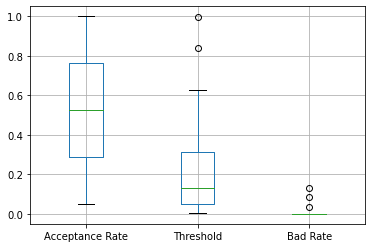

In [70]:
# Visualize the distributions in the strategy table with a boxplot
strat_df.boxplot()
plt.show()

<ipython-input-71-b53c2c41f710>:6: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.axes().yaxis.grid()
<ipython-input-71-b53c2c41f710>:7: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.axes().xaxis.grid()


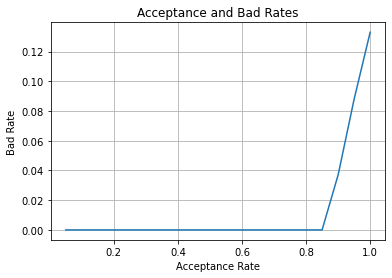

In [71]:
# Plot the strategy curve
plt.plot(strat_df['Acceptance Rate'], strat_df['Bad Rate'])
plt.xlabel('Acceptance Rate')
plt.ylabel('Bad Rate')
plt.title('Acceptance and Bad Rates')
plt.axes().yaxis.grid()
plt.axes().xaxis.grid()
plt.show()